In [1]:
import pandas as pd

titanic_data = pd.read_csv('train.csv')
titanic_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Check for missing values in the dataset
missing_values = titanic_data.isnull().sum()

missing_values_percentage = (missing_values / len(titanic_data)) * 100

# Display the count and percentage of missing values for each column
missing_values_df = pd.DataFrame({'Count': missing_values, 'Percentage': missing_values_percentage})
missing_values_df.sort_values(by='Percentage', ascending=False)


,Count,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


The **Cabin** column has a lot of missing data, but it is not much useful for network analysis. So we will skip it.

Using family names will be useful to find the relation between the people. So, let's create a column for that.

In [3]:

def extract_last_name(name):
    return name.split(',')[0].strip()

# Function to extract the title
def extract_title(name):
    return name.split(',')[1].split('.')[0].strip()

# Apply the functions to the dataset
titanic_data['LastName'] = titanic_data['Name'].apply(extract_last_name)
titanic_data['Title'] = titanic_data['Name'].apply(extract_title)

# Displaying the modified dataframe to check the new columns
titanic_data[['Name', 'LastName', 'Title']].head()


,Name,LastName,Title
0,"Braund, Mr. Owen Harris",Braund,Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs
2,"Heikkinen, Miss. Laina",Heikkinen,Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs
4,"Allen, Mr. William Henry",Allen,Mr



We will impute **Age** column based on the median age of passengers grouped by `Pclass` and `Title`.

In [4]:
median_ages = titanic_data.groupby(['Pclass', 'Title'])['Age'].median()
def impute_age(row):
    if pd.isna(row['Age']):
        return median_ages[row['Pclass'], row['Title']]
    else:
        return row['Age']

titanic_data['Age'] = titanic_data.apply(impute_age, axis=1)

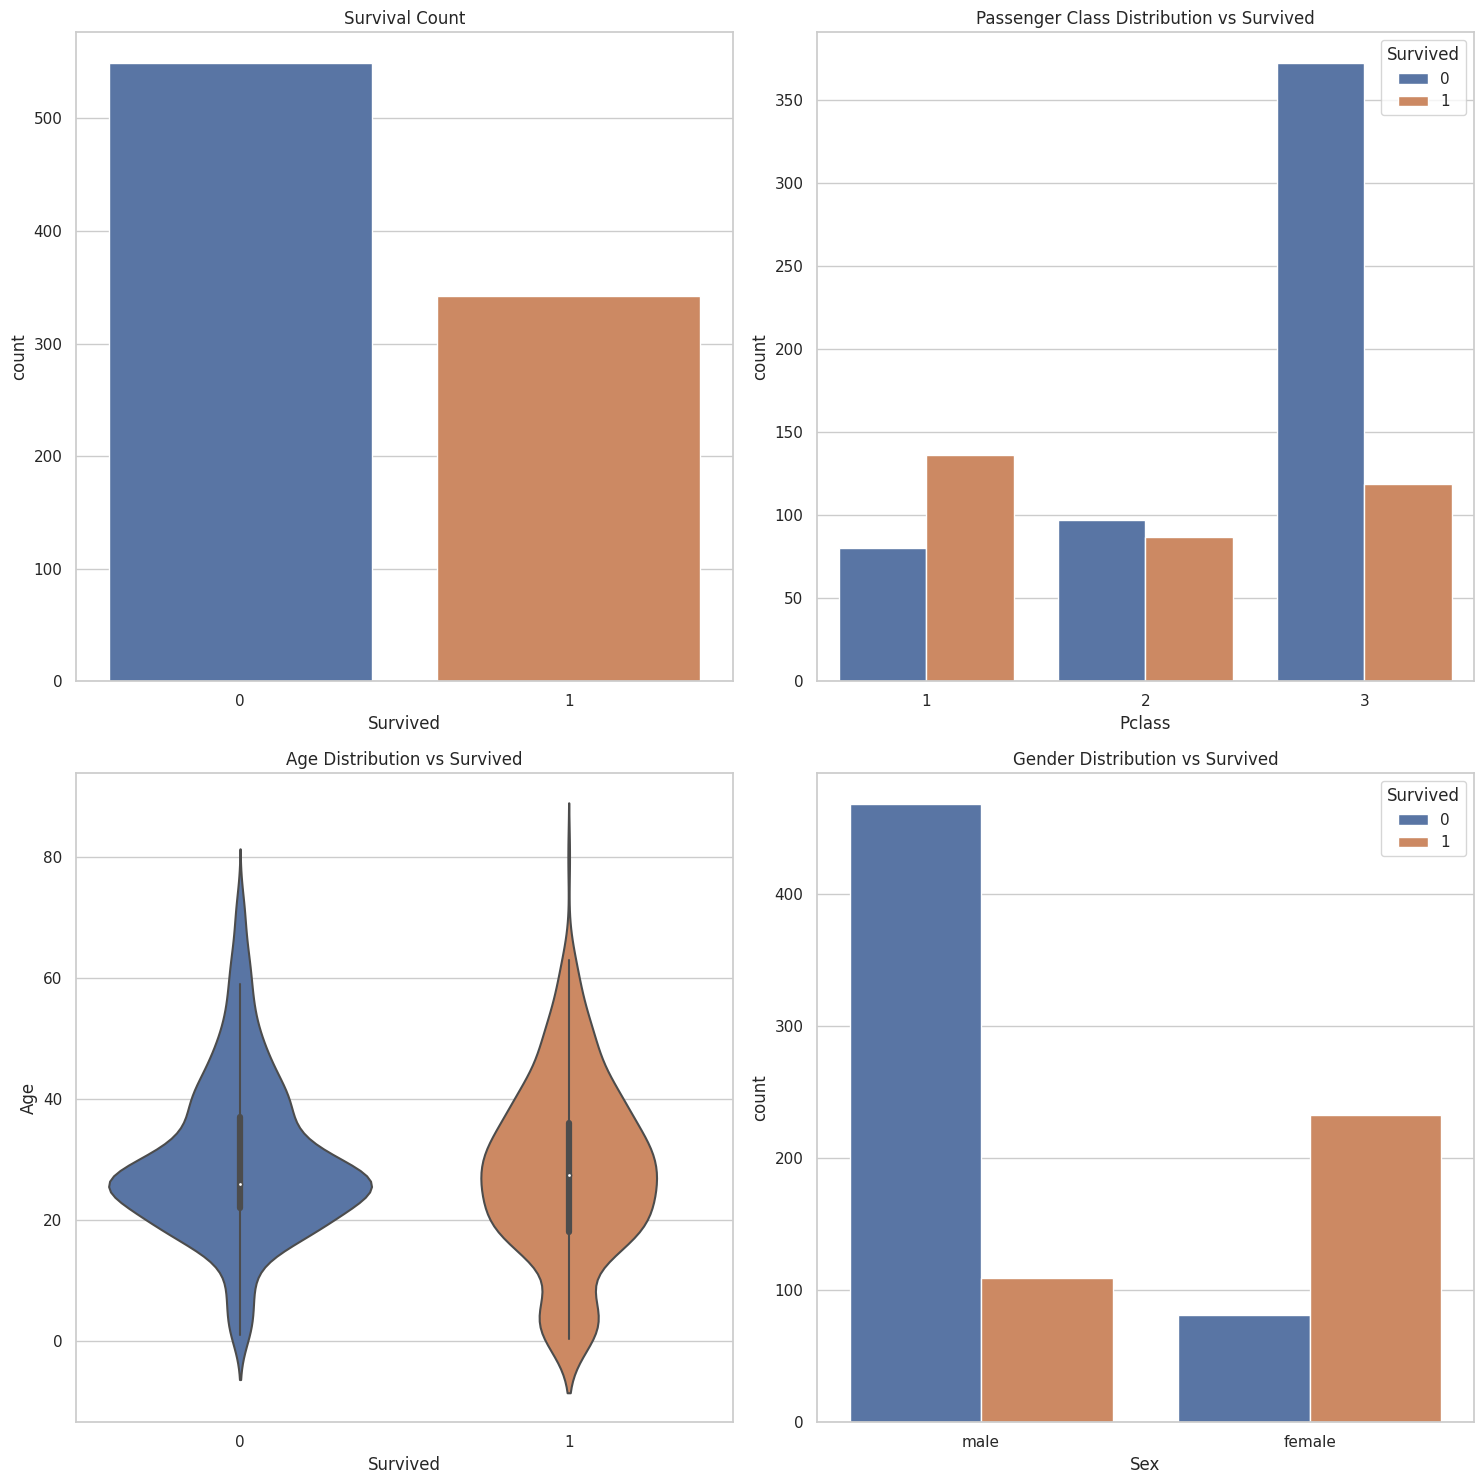

In [5]:
# Importing seaborn for the visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Bar chart for Survived vs Not-Survived
sns.countplot(x='Survived', data=titanic_data, ax=axes[0, 0])
axes[0, 0].set_title('Survival Count')

# Bar chart for Passenger Class Distribution vs Survived
sns.countplot(x='Pclass', hue='Survived', data=titanic_data, ax=axes[0, 1])
axes[0, 1].set_title('Passenger Class Distribution vs Survived')

# Violin plot for Age Distribution vs Survived
sns.violinplot(x='Survived', y='Age', data=titanic_data, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution vs Survived')

# Bar chart for Gender Distribution vs Survived
sns.countplot(x='Sex', hue='Survived', data=titanic_data, ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution vs Survived')
plt.tight_layout()
plt.show()


In [6]:
# Analyzing the Ticket data

# Identifying unique ticket numbers and the number of passengers sharing each ticket
ticket_counts = titanic_data['Ticket'].value_counts()

# Grouping passengers by Ticket number
grouped_by_ticket = titanic_data.groupby('Ticket').agg({'PassengerId': 'count', 'Survived': 'mean', 'Pclass': 'mean', 'Age': 'mean', 'Fare': 'mean'})

# Displaying some ticket groups and their details
grouped_by_ticket.head(), ticket_counts.head()


(        PassengerId  Survived  Pclass        Age   Fare
 Ticket                                                 
 110152            3  1.000000     1.0  26.333333  86.50
 110413            3  0.666667     1.0  36.333333  79.65
 110465            2  0.000000     1.0  43.500000  52.00
 110564            1  1.000000     1.0  28.000000  26.55
 110813            1  1.000000     1.0  60.000000  75.25,
 347082      7
 CA. 2343    7
 1601        7
 3101295     6
 CA 2144     6
 Name: Ticket, dtype: int64)

In [7]:
import networkx as nx

# Creating the network
G = nx.Graph()

# Adding nodes with attributes
for idx, row in titanic_data.iterrows():
    G.add_node(row['PassengerId'],
               pclass=row['Pclass'],
               age=row['Age'],
               sex=row['Sex'],
               survived=row['Survived'],
               title=row['Title'])

# Adding edges for family relationships (based on last name)
for _, group in titanic_data.groupby('LastName'):
    if len(group) > 1:  # If more than one person shares a last name
        for idx1, passenger1 in group.iterrows():
            for idx2, passenger2 in group.iterrows():
                if idx1 < idx2:  # To avoid adding the same edge twice
                    G.add_edge(passenger1['PassengerId'], passenger2['PassengerId'], relation='family')

# Adding edges for shared ticket numbers
for _, group in titanic_data.groupby('Ticket'):
    if len(group) > 1:  # If more than one person shares a ticket
        for idx1, passenger1 in group.iterrows():
            for idx2, passenger2 in group.iterrows():
                if idx1 < idx2:  # To avoid adding the same edge twice
                    G.add_edge(passenger1['PassengerId'], passenger2['PassengerId'], relation='ticket')

# Checking the basic stats of the created network
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges


(891, 491)

In [8]:
import networkx as nx

# Creating a network graph
G = nx.Graph()

# Adding nodes
# Each passenger is a node with attributes like Age, Sex, and Survival status
for index, row in titanic_data.iterrows():
    G.add_node(row['PassengerId'],
               age=row['Age'],
               sex=row['Sex'],
               survived=row['Survived'],
               pclass=row['Pclass'])

# Adding edges for family connections
# Edges between family members based on last names and 'SibSp'/'Parch' data
for index, row in titanic_data.iterrows():
    family_members = titanic_data[(titanic_data['LastName'] == row['LastName']) &
                                  (titanic_data['PassengerId'] != row['PassengerId'])]
    for _, member in family_members.iterrows():
        if not G.has_edge(row['PassengerId'], member['PassengerId']):
            G.add_edge(row['PassengerId'], member['PassengerId'], relationship='family')

# Adding edges for travel companions
# Edges between passengers sharing ticket numbers
for index, row in titanic_data.iterrows():
    companions = titanic_data[(titanic_data['Ticket'] == row['Ticket']) &
                              (titanic_data['PassengerId'] != row['PassengerId'])]
    for _, companion in companions.iterrows():
        if not G.has_edge(row['PassengerId'], companion['PassengerId']):
            G.add_edge(row['PassengerId'], companion['PassengerId'], relationship='travel_companion')

# Checking the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges


(891, 491)

In [9]:
# Creating two separate graphs for family connections and travel companions
family_graph = nx.Graph()
travel_companion_graph = nx.Graph()

# Adding nodes to both graphs
for node, data in G.nodes(data=True):
    family_graph.add_node(node, **data)
    travel_companion_graph.add_node(node, **data)

# Adding family connection edges to the family graph
for u, v, data in G.edges(data=True):
    if data['relationship'] == 'family':
        family_graph.add_edge(u, v)

# Adding travel companion connection edges to the travel companion graph
for u, v, data in G.edges(data=True):
    if data['relationship'] == 'travel_companion':
        travel_companion_graph.add_edge(u, v)

# Creating subgraphs for survivors in both family and travel companion graphs
family_graph_survivors = family_graph.subgraph([n for n, attr in family_graph.nodes(data=True) if attr['survived'] == 1])
travel_companion_graph_survivors = travel_companion_graph.subgraph([n for n, attr in travel_companion_graph.nodes(data=True) if attr['survived'] == 1])

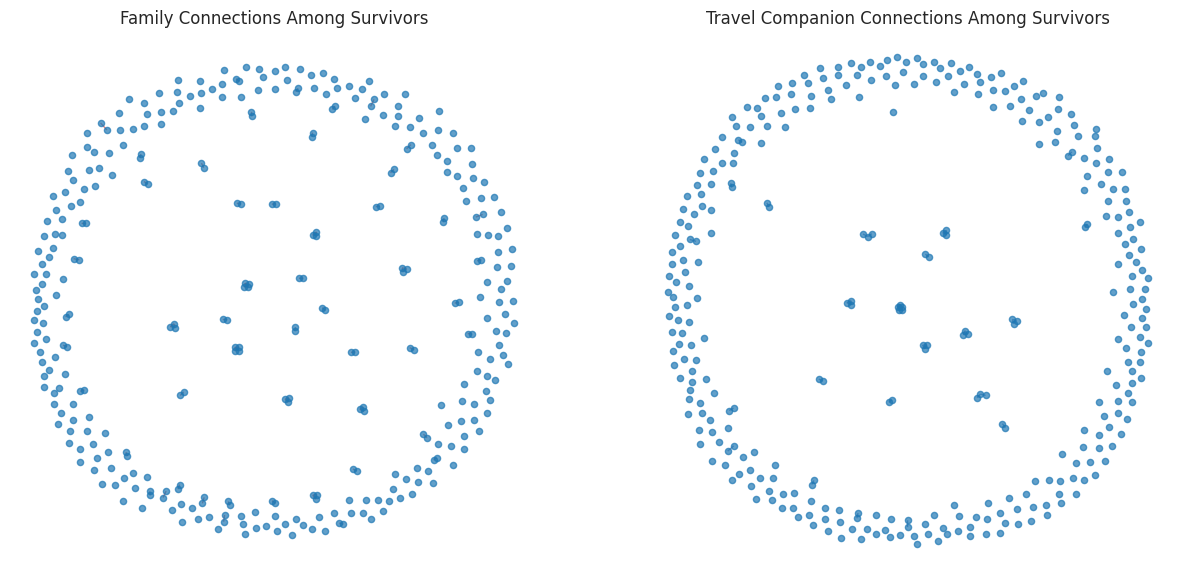

In [10]:
# Creating subgraphs for survivors in both family and travel companion graphs
family_graph_survivors = family_graph.subgraph([n for n, attr in family_graph.nodes(data=True) if attr['survived'] == 1])
travel_companion_graph_survivors = travel_companion_graph.subgraph([n for n, attr in travel_companion_graph.nodes(data=True) if attr['survived'] == 1])

# Visualization of the survivor subgraphs
plt.figure(figsize=(15, 7))

# Family Connections Graph - Survivors Only
plt.subplot(1, 2, 1)
nx.draw_spring(family_graph_survivors, node_size=20, alpha=0.7, with_labels=False, edge_color='r')
plt.title('Family Connections Among Survivors')

# Travel Companion Connections Graph - Survivors Only
plt.subplot(1, 2, 2)
nx.draw_spring(travel_companion_graph_survivors, node_size=20, alpha=0.7, with_labels=False, edge_color='b')
plt.title('Travel Companion Connections Among Survivors')

plt.show()


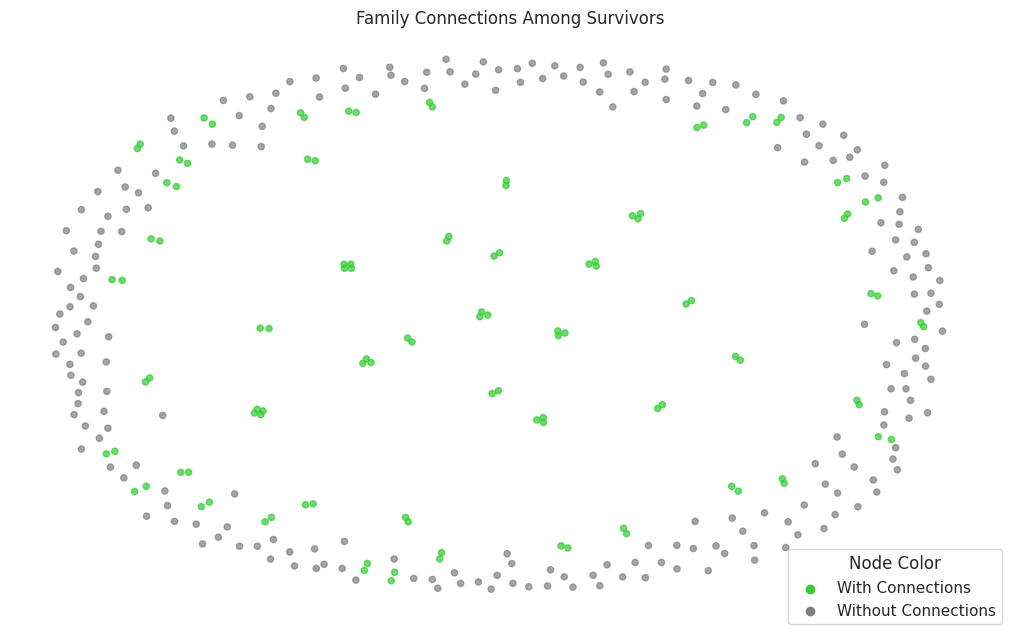

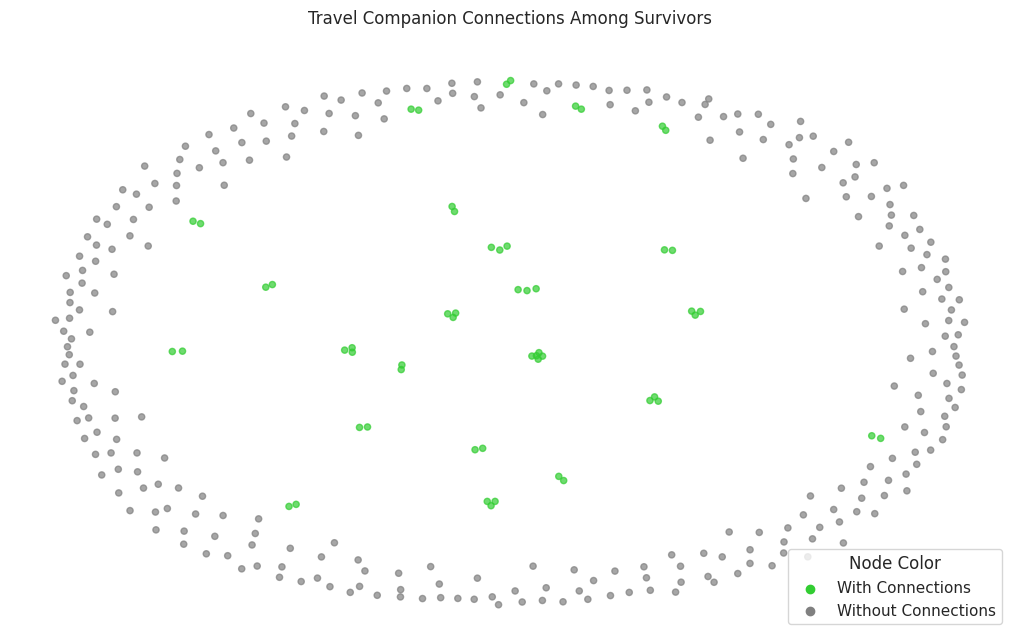

In [11]:
# Creating separate graph plots for Family and Travel Companion connections among survivors

# Function to assign colors based on whether a node has connections or not
def assign_node_colors(graph):
    colors = []
    for node in graph:
        if graph.degree(node) > 0:  # Node has connections
            colors.append('limegreen')  # Color for nodes with connections
        else:
            colors.append('grey')  # Color for nodes without connections
    return colors

# Family Connections Graph - Survivors with Contrasting Node Colors based on connections
node_colors_family = assign_node_colors(family_graph_survivors)

# Travel Companion Connections Graph - Survivors with Contrasting Node Colors based on connections
node_colors_travel = assign_node_colors(travel_companion_graph_survivors)

# Family Connections Graph - Survivors with Contrasting Node Colors (Edges Invisible)
plt.figure(figsize=(10, 6))
nx.draw_spring(family_graph_survivors, node_size=20, alpha=0.7, with_labels=False, node_color=node_colors_family, edge_color='white')
plt.title('Family Connections Among Survivors')
# Adjusting legend placement for Family Connections Graph
plt.scatter([], [], c='limegreen', label='With Connections')
plt.scatter([], [], c='grey', label='Without Connections')
plt.legend(title="Node Color", loc='lower right')
plt.show()

# Travel Companion Connections Graph - Survivors with Contrasting Node Colors (Edges Invisible)
plt.figure(figsize=(10, 6))
nx.draw_spring(travel_companion_graph_survivors, node_size=20, alpha=0.7, with_labels=False, node_color=node_colors_travel, edge_color='white')
plt.title('Travel Companion Connections Among Survivors')
# Adjusting legend placement for Travel Companion Connections Graph
plt.scatter([], [], c='limegreen', label='With Connections')
plt.scatter([], [], c='grey', label='Without Connections')
plt.legend(title="Node Color", loc='lower right')
plt.show()


In [12]:
# Checking the number of nodes and edges in the graph
num_nodes = family_graph_survivors.number_of_nodes()
num_edges = family_graph_survivors.number_of_edges()

print(num_nodes, num_edges)

# Checking the number of nodes and edges in the graph
num_nodes2 = travel_companion_graph_survivors.number_of_nodes()
num_edges2 = travel_companion_graph_survivors.number_of_edges()

print(num_nodes2, num_edges2)


342 74
342 44


In [13]:
family_graph_survivors_connected = nx.subgraph(family_graph_survivors, [node for node in family_graph_survivors if family_graph_survivors.degree(node) > 0])
travel_companion_graph_survivors_connected = nx.subgraph(travel_companion_graph_survivors, [node for node in travel_companion_graph_survivors if travel_companion_graph_survivors.degree(node) > 0])


In [14]:
# Calculating network metrics for the survivors' networks

# Degree Centrality - Number of connections each node has
degree_centrality_family = nx.degree_centrality(family_graph_survivors_connected)
degree_centrality_travel = nx.degree_centrality(travel_companion_graph_survivors_connected)

# Betweenness Centrality - Measures the extent to which a node lies on paths between other nodes
betweenness_centrality_family = nx.betweenness_centrality(family_graph_survivors_connected)
betweenness_centrality_travel = nx.betweenness_centrality(travel_companion_graph_survivors_connected)

# Converting the centrality measures to DataFrame for easier analysis
degree_df_family = pd.DataFrame(degree_centrality_family.items(), columns=['PassengerId', 'DegreeCentrality']).sort_values(by='DegreeCentrality', ascending=False)
betweenness_df_family = pd.DataFrame(betweenness_centrality_family.items(), columns=['PassengerId', 'BetweennessCentrality']).sort_values(by='BetweennessCentrality', ascending=False)

degree_df_travel = pd.DataFrame(degree_centrality_travel.items(), columns=['PassengerId', 'DegreeCentrality']).sort_values(by='DegreeCentrality', ascending=False)
betweenness_df_travel = pd.DataFrame(betweenness_centrality_travel.items(), columns=['PassengerId', 'BetweennessCentrality']).sort_values(by='BetweennessCentrality', ascending=False)

degree_df_family.head(), betweenness_df_family.head(), degree_df_travel.head(), betweenness_df_travel.head()


(     PassengerId  DegreeCentrality
 105          449          0.026549
 69           803          0.026549
 91           859          0.026549
 63           764          0.026549
 101          436          0.026549,
     PassengerId  BetweennessCentrality
 0             9                    0.0
 85          850                    0.0
 83          331                    0.0
 82          330                    0.0
 81          329                    0.0,
     PassengerId  DegreeCentrality
 55          510          0.072727
 24          693          0.072727
 4           644          0.072727
 34          839          0.072727
 35           75          0.072727,
     PassengerId  BetweennessCentrality
 19          307               0.000673
 17          682               0.000673
 0           258               0.000000
 41          597               0.000000
 31          709               0.000000)

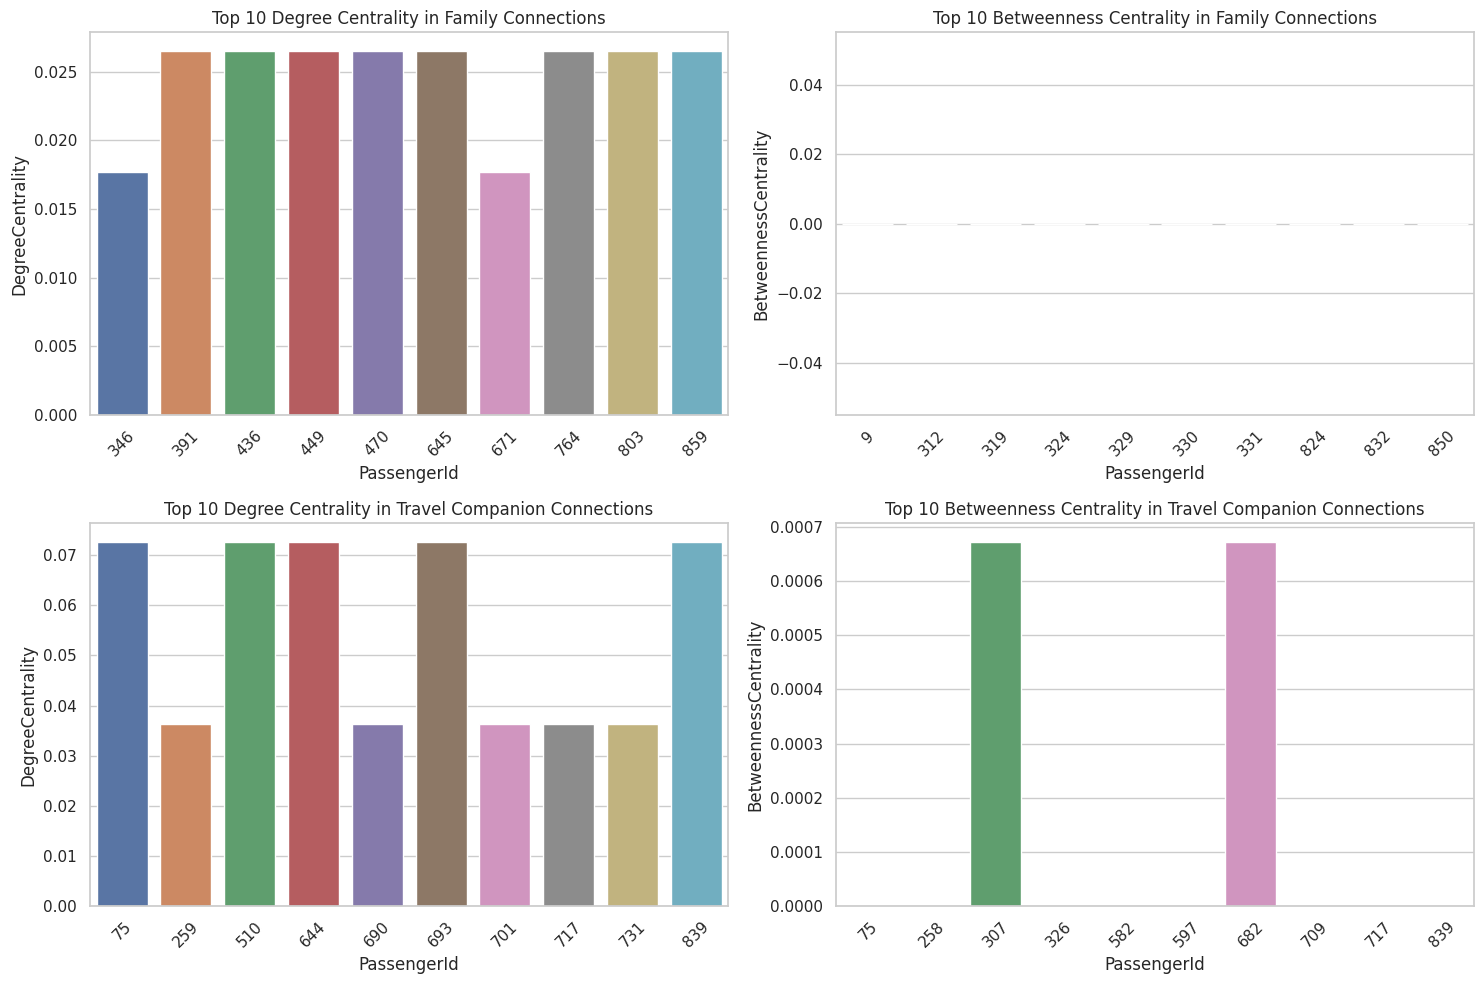

In [15]:
# Visualization of network metrics for both family and travel companion connections among survivors

plt.figure(figsize=(15, 10))

# Degree Centrality Visualization for Family Connections
plt.subplot(2, 2, 1)
sns.barplot(x='PassengerId', y='DegreeCentrality', data=degree_df_family.head(10))
plt.title('Top 10 Degree Centrality in Family Connections')
plt.xticks(rotation=45)

# Betweenness Centrality Visualization for Family Connections
plt.subplot(2, 2, 2)
sns.barplot(x='PassengerId', y='BetweennessCentrality', data=betweenness_df_family.head(10))
plt.title('Top 10 Betweenness Centrality in Family Connections')
plt.xticks(rotation=45)

# Degree Centrality Visualization for Travel Companion Connections
plt.subplot(2, 2, 3)
sns.barplot(x='PassengerId', y='DegreeCentrality', data=degree_df_travel.head(10))
plt.title('Top 10 Degree Centrality in Travel Companion Connections')
plt.xticks(rotation=45)

# Betweenness Centrality Visualization for Travel Companion Connections
plt.subplot(2, 2, 4)
sns.barplot(x='PassengerId', y='BetweennessCentrality', data=betweenness_df_travel.head(10))
plt.title('Top 10 Betweenness Centrality in Travel Companion Connections')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [16]:
# Calculating survival rates for passengers based on whether they had connections (edges > 0) or not (edges = 0)
# Using the full graph (G) which includes both survivors and non-survivors

# Creating a list of passenger IDs who had connections (edges > 0) and who did not (edges = 0)
passengers_with_connections = [node for node in G.nodes() if G.degree(node) > 0]
passengers_without_connections = [node for node in G.nodes() if G.degree(node) == 0]

# Extracting survival information for these passengers from the original dataset
survival_with_connections = titanic_data[titanic_data['PassengerId'].isin(passengers_with_connections)]['Survived'].mean()
survival_without_connections = titanic_data[titanic_data['PassengerId'].isin(passengers_without_connections)]['Survived'].mean()

print(f'Survival with connections: {survival_with_connections * 100}%')
print(f'Survival without connections: {survival_without_connections * 100}%')

Survival with connections: 45.4337899543379%
Survival without connections: 31.567328918322296%
